In [422]:
from MNIST_dataloader import Noisy_MNIST
from Fast_MRI_dataloader import Fast_MRI
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torch.utils.data import TensorDataset
import glob
import numpy as np
from tqdm import tqdm 
from PIL import Image
import numpy as np
import scipy.fft as fft
from torch.fft import fft2, fftshift, ifft2, ifftshift

In [423]:
# %% dataloader for the Fast MRI dataset
def create_dataloaders_mri(data_loc, batch_size):
    dataset_train = Fast_MRI("train", data_loc)
    dataset_test  = Fast_MRI("test" , data_loc)
    
    Fast_MRI_train_loader =  DataLoader(dataset_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Fast_MRI_test_loader  =  DataLoader(dataset_test , batch_size=batch_size, shuffle=True, drop_last=False)
    
    return Fast_MRI_train_loader, Fast_MRI_test_loader

In [424]:
# Bram
data_loc = 'D://5LSL0-Datasets//Fast_MRI_Knee' #change the datalocation to something that works for you

# define parameters
batch_size = 5

train_loader, test_loader = create_dataloaders_mri(data_loc, batch_size)

# go over the dataset
for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
    if i == 1:
        break

  2%|▏         | 1/49 [00:00<00:06,  8.00it/s]


In [425]:
# Define function to achieve Full k-space
def get_k_space(inputs):
    k_space = fftshift(fft2(inputs))
    return k_space

# Define function to achieve Partial k-space from Full k-space and Mask
def get_partial_k_space(k_space,M):
    return  torch.mul(k_space, M)

# Define function Accelerated MRI from Partial k-space
def get_accelerate_MRI(inputs):
    return ifft2(inputs)

# Define function Accelerated MRI from Partial k-space (shift on the input array to center the zero frequency)
def get_accelerate_MRI_final(inputs):
    return ifft2(ifftshift(inputs))


In [426]:
# Define soft_treshhold function
def soft_threshold(input, threshold) :
    idx = torch.abs(input) > threshold
    input[idx] = input[idx] * (torch.abs(input[idx]) - threshold)/torch.abs(input[idx])
    input[~idx] = 0
        
    return input

In [427]:
def ISTA(mu, shrinkage, K, k_space, M) :

    # get accelerated MRI image from partial k-space
    y = get_accelerate_MRI(k_space)
    #y = torch.log(torch.abs(y)+1e-20)
    
    image_list = []

    for idx, (y, M) in enumerate(zip (y,M)):
    
        # initialize 
        x_t = y
    
        for i in range(K):

            # soft thresholding
            x_t = soft_threshold(x_t, shrinkage)
            F_x = get_k_space(x_t)
            k_space_y = get_k_space(y)
            
            z = F_x - mu * get_partial_k_space(F_x, M) + mu * k_space_y

            x_t = get_accelerate_MRI_final(z)


        # store the results
        image_list.append(x_t)

    # convert to tensor
    x_out = torch.stack(image_list,dim=0).float()

    return x_out

In [428]:
# Define constants
mu = 0.1
K = 50
shrinkage = 0.01

In [429]:
# Run functions to get MRI images
x_t = ISTA(mu, shrinkage, K, kspace, M)     # Run ISTA Algorithm
x_t_plot = torch.log(torch.abs(x_t)+1e-20)  # Achieve plot friendly values

# Get accelerated MRI input
accelerated_mri_input = get_accelerate_MRI(kspace)
accerated_plot = torch.log(torch.abs(accelerated_mri_input)+1e-20)

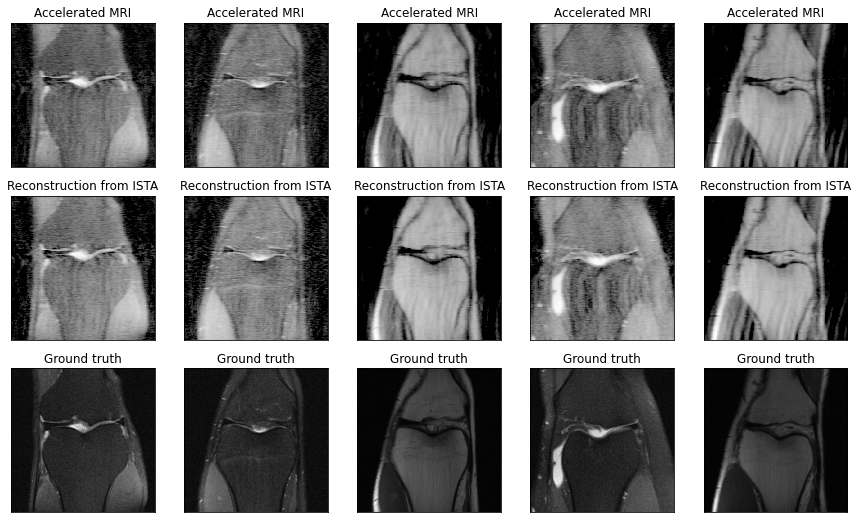

In [430]:
# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 5

# Create a figure and subplots with the desired grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 9))

# Loop over the batch_size
for i in range(batch_size):
    # Plot Accelerated MRI
    axs[i//num_cols, i%num_cols].imshow(accerated_plot[i, :, :], vmin=-2, interpolation='nearest', cmap='gray')
    axs[i//num_cols, i%num_cols].set_xticks([])
    axs[i//num_cols, i%num_cols].set_yticks([])
    axs[i//num_cols, i%num_cols].set_title('Accelerated MRI')

    # Plot Reconstruction from ISTA
    axs[(i+num_cols)//num_cols, (i+num_cols)%num_cols].imshow(x_t_plot[i, :, :], vmin=-1, interpolation='nearest', cmap='gray')
    axs[(i+num_cols)//num_cols, (i+num_cols)%num_cols].set_xticks([])
    axs[(i+num_cols)//num_cols, (i+num_cols)%num_cols].set_yticks([])
    axs[(i+num_cols)//num_cols, (i+num_cols)%num_cols].set_title('Reconstruction from ISTA')

    # Plot Ground truth
    axs[(i+2*num_cols)//num_cols, (i+2*num_cols)%num_cols].imshow(gt[i, :, :], cmap='gray')
    axs[(i+2*num_cols)//num_cols, (i+2*num_cols)%num_cols].set_xticks([])
    axs[(i+2*num_cols)//num_cols, (i+2*num_cols)%num_cols].set_yticks([])
    axs[(i+2*num_cols)//num_cols, (i+2*num_cols)%num_cols].set_title('Ground truth')


# Save figure
plt.savefig("Comparison_3b.png",dpi=500,bbox_inches='tight')
# Show the figure
plt.show()

In [431]:
mse = torch.nn.MSELoss()
LISTA_mse_losses = 0

for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):

    x_t_test = ISTA(mu, shrinkage, K, kspace, M)

    # compute MSE
    mse_loss = mse(x_out_ISTA, gt)

    # ADD TO TOTAL LOSS
    LISTA_mse_losses += mse_loss.item()

    # set the loss to zero for next iteration
    loss = 0

100%|██████████| 49/49 [01:03<00:00,  1.29s/it]


In [432]:
print(f'test_loss = {LISTA_mse_losses/len(test_loader)}') 

test_loss = 3.762993082708242
